# Проект №3: Exploratory Data Analysis and Feature Engineering #

**Подробное описание постановки задачи, ссылки на Kaggle (Competition + Notebook) приведены в файле [README.md](README.md)**

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from scipy import stats
import category_encoders as ce

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

DATA_PATH = 'data/'
# DATA_PATH = '/kaggle/input/sf-booking/'
OUTPUT_PATH = 'output/'
# OUTPUT_PATH = ''
RANDOM_STATE = 42

## Сбор и предварительный анализ данных (Data Collection) ##

In [2]:
train_ini = pd.read_csv(DATA_PATH + 'hotels_train.csv')
test_ini = pd.read_csv(DATA_PATH + 'hotels_test.csv')
submission_df = pd.read_csv(DATA_PATH + 'submission.csv')

In [3]:
# Далее временно удобно работать с копиями датасетов
train_df = train_ini.copy()
test_df = test_ini.copy()

In [4]:
train_df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
# Проверка на одновременное отстутствие 'lat' и 'lng' в одной строке
for df_ in train_df, test_df:
    print(df_.isna().sum(axis='columns').value_counts())

0    384355
2      2448
dtype: int64
0    128115
2       820
dtype: int64


Видно, что в обоих датасетах есть незаполненные координаты широты и долготы. Причём они отсутствуют одновременно, то есть нет строк с одной заполненной координатой, что немного упрощает дальнейшую работу.

Можно сразу преобразовать **`review_date`** в формат **`datetime`** и посмотреть, в какой период собирались данные.

In [8]:
for df_ in train_df, test_df:
    df_.review_date = pd.to_datetime(df_.review_date)

print(f'TRAIN_DF: данные с {train_df.review_date.min()} по {train_df.review_date.max()}')
print(f'TEST_DF: данные с {test_df.review_date.min()} по {test_df.review_date.max()}')

TRAIN_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00
TEST_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00


В обоих датасетах данные собраны с 4 августа 2015 по 4 августа 2017.

## Стратегия дальнейшей работы ##

Так как в данном проекте метод обучения модели фиксирован (RandomForestRegressor), и задан критерий качества модели&nbsp;&mdash; достижение минимального значения MAPE (Mean Absolute Percentage Error), то вместо последовательных этапов работы с данными (очистка, создание, преобразование, отбор) представляется более интересной следующая стратегия:

Первой итерацией будет простой отбор всех имеющихся числовых признаков и получение первого значения MAPE, от которого потом можно &laquo;плясать&raquo; далее по такому циклу:

1. Берём признак и смотрим, что можно сделать с числовым признаком (непрерывный/категориальный, распределение нормальное/нет, необходимость нормализации, стандартизации и других преобразований)
2. То же и с строковым признаком (что можно вытянуть из строк сначала в числа или категории, далее &laquo;GOTO пункт 1&raquo;).
3. Отбор признаков (устранение излишней корреляции и мультиколлинеарности).
4. Обучение модели, отслеживание MAPE и анализ важности признаков.

Может быть получится излишне трудоёмко, но главная цель представляется как проработка процесса подготовки данных для готовой модели.

### 1. **`hotel_address`**, **`lat`**, **`lng`**: One-hot-кодирование признаков города из **`hotel_address`** и заполнение недостающих **`lat`** и **`lng`** среднегородскими значениями ###

In [9]:
# Создание временного логического признака 'lost_hotel'
# (где координаты отсутствуют)
for df_ in train_df, test_df:
    df_['lost_hotel'] = df_.lat.isna()

print(f'TRAIN_DF: {train_df.hotel_address.nunique()} уникальных адресов отелей')
print(f'TEST_DF: {test_df.hotel_address.nunique()} уникальных адресов отелей\n')

print(f'TRAIN_DF: {train_df.lng.nunique()} уникальных долгот')
print(f'TEST_DF: {test_df.lng.nunique()} уникальных долгот\n')

print(f'TRAIN_DF: {train_df.lat.nunique()} уникальных широт')
print(f'TEST_DF: {test_df.lat.nunique()} уникальных широт\n')

print(f'TRAIN_DF: {train_df[train_df.lost_hotel].hotel_address.nunique()} отелей без координат')
print(f'TEST_DF: {test_df[test_df.lost_hotel].hotel_address.nunique()} отелей без координат')

TRAIN_DF: 1493 уникальных адресов отелей
TEST_DF: 1493 уникальных адресов отелей

TRAIN_DF: 1472 уникальных долгот
TEST_DF: 1472 уникальных долгот

TRAIN_DF: 1472 уникальных широт
TEST_DF: 1472 уникальных широт

TRAIN_DF: 17 отелей без координат
TEST_DF: 17 отелей без координат


Итак, мы имеем дело всего с **1493** отелями. Для них есть **1473** уникальных координат и всего **17** отелей без координат (далее&nbsp;&mdash; &laquo;потерянные отели&raquo;, `lost_hotel` для удобства). Видимо, ещё у **3** оставшихся отелей координаты могут совпадать с какими-то другими.

Ещё можно посмотреть структуру содержимого **`hotel_address`**:

In [10]:
for str_ in train_df.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Структура ясна, можно посчитать число стран и городов, встречающихся во всех адресах:

In [11]:
countries = set()
cities = set()
for str_ in train_df.hotel_address:
    addr_ = str_.split()
    countries.add(addr_[-1])
    if addr_[-1] == 'Kingdom':
        cities.add(addr_[-5])
    else:
        cities.add(addr_[-2])
print(f'Всего {len(countries)} стран: {countries}')
print(f'Всего {len(cities)} городов: {cities}')

Всего 6 стран: {'France', 'Netherlands', 'Austria', 'Italy', 'Kingdom', 'Spain'}
Всего 6 городов: {'London', 'Vienna', 'Paris', 'Amsterdam', 'Milan', 'Barcelona'}


Выяснилось, что в обучающем и тестовом датасетах содержатся отели только из шести городов однозначно соответствующих шести стран. Тогда в обоих датасетах можно сделать следующее:

Извлекаем название город из **`hotel_address`** во временный признак **`city`**

In [12]:
def get_city(addr_str: str) -> str:
    ''' Находит в строке адреса название города
    Arguments:
        addr_str [str] -- Содержимое ячейки признака 'hotel_address'
    Returns:
        [str] -- Название города
    '''
    words_list = addr_str.split()
    if words_list[-1] == 'Kingdom':
        return words_list[-5]
    else:
        return words_list[-2]
    return 'Unknown'

# Создание временного признака 'city' для города
for df_ in train_df, test_df:
    df_['city'] = df_.hotel_address.apply(get_city)

Интересно узнать количество потерянных отелей по городам в обучающем датасете (в тестовом то же самое, проверено):

In [13]:
# Выделение строк с потерянными отелями в отдельные датафреймы
train_lost_hotel_df = train_df[train_df.lost_hotel]
test_lost_hotel_df = test_df[test_df.lost_hotel]

city_list = train_lost_hotel_df.city.unique()
for city_ in city_list:
    print(
        city_ + ':',
        train_lost_hotel_df[train_lost_hotel_df.city == city_].hotel_address.nunique(),
        'потерянных отелей'
    )

Vienna: 11 потерянных отелей
Paris: 3 потерянных отелей
Barcelona: 3 потерянных отелей


У нас не так уж много потерянных отелей. Можно даже заполнить их **`lat`** и **`lng`** вручную истинными координатами, определёнными по адресам, но можно поступить проще. Поскольку пара значений `(lat, lng)` представляют своего рода уникальный идентификатор, то достаточно каждому адресу отеля сопоставить такую уникальную числовую пару. Почти &laquo;от фонаря&raquo;. Например, чтобы не сильно портить статисткику распределения, для 17 отелей назначить пары в пределах IQR (от Q25 до Q75) для каждого из трёх городов.

In [15]:
# Составление словаря адресов потерянных отелей (key)
# с новыми координатами (value)
lost_hotel_coords_dict = {}
for city_ in ['Vienna', 'Paris', 'Barcelona']:
    # Выборки для конкретного города
    df = train_df[train_df.city == city_]
    lost_hotel_df = train_lost_hotel_df[train_lost_hotel_df.city == city_]
    # Список адресов потерянных отелей в городе
    lost_hotel_addr_list = list(lost_hotel_df.hotel_address.unique())
    lost_hotel_count = len(lost_hotel_addr_list)
    # Определение границ IQR для 'lat' и 'lng'
    lat_q25 = df.lat.quantile(0.25)
    lat_q75 = df.lat.quantile(0.75)
    lng_q25 = df.lng.quantile(0.25)
    lng_q75 = df.lng.quantile(0.75)
    # Формирование наборов значений для 'lat' и 'lng'
    lat_tuple = tuple(np.linspace(lat_q25, lat_q75, lost_hotel_count))
    lng_tuple = tuple(np.linspace(lng_q25, lng_q75, lost_hotel_count))
    # Формирование словаря
    coords_dict = dict(zip(lost_hotel_addr_list, zip(lat_tuple, lng_tuple)))
    lost_hotel_coords_dict.update(coords_dict)

# Составление списков индексов строк с потерянными отелями
train_lost_hotel_index_list = list(train_lost_hotel_df.index)
test_lost_hotel_index_list = list(test_lost_hotel_df.index)

# Заполнение отсутствующих координат в обучающем датасете
for i_ in train_lost_hotel_index_list:
    new_coords = lost_hotel_coords_dict.get(train_df.hotel_address.iloc[i_])
    train_df.lat.iloc[i_] = new_coords[0]
    train_df.lng.iloc[i_] = new_coords[1]

# Заполнение отсутствующих координат в тестовом датасете
for i_ in test_lost_hotel_index_list:
    new_coords = lost_hotel_coords_dict.get(test_df.hotel_address.iloc[i_])
    test_df.lat.iloc[i_] = new_coords[0]
    test_df.lng.iloc[i_] = new_coords[1]

display(train_df.info())
display(test_df.info())

<ipython-input-15-6df8cfdd38e8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.lat.iloc[i_] = new_coords[0]
<ipython-input-15-6df8cfdd38e8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.lng.iloc[i_] = new_coords[1]
<ipython-input-15-6df8cfdd38e8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.lat.iloc[i_] = new_coords[0]
<ipython-input-15-6df8cfdd38e8>:37: SettingWithCopyWarning: 
A value is trying t

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               128935 non-null  object        
 1   additional_number_of_scoring                128935 non-null  int64         
 2   review_date                                 128935 non-null  datetime64[ns]
 3   average_score                               128935 non-null  float64       
 4   hotel_name                                  128935 non-null  object        
 5   reviewer_nationality                        128935 non-null  object        
 6   negative_review                             128935 non-null  object        
 7   review_total_negative_word_counts           128935 non-null  int64         
 8   total_number_of_reviews                     128935 non-null  int64        

None

Заполняем пустые ячейки в признаках **`lat`** и **`lng`** координатами центров соответствующих городов (взяты из внешних источников)

In [14]:
for df_ in train_df, test_df:
    df_.lat.fillna(0, inplace=True)
    df_.lng.fillna(0, inplace=True)

''' Координаты центров городов (lat, lng) из внешних источников '''
CITY_COORDS = {
    'Amsterdam': (52.383333, 4.9),
    'Barcelona': (41.383333, 2.183333),
    'London': (51.507222, -0.1275),
    'Milan': (45.466667, 9.166667),
    'Paris': (48.833333, 2.333333),
    'Vienna': (48.216667, 16.373333)
}

def write_lat(city_: str, lat_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение широты в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        lat_ [float] -- Широта
    Returns:
        [float] -- Широта (lattitude)
    '''
    if lat_ == 0:
        return CITY_COORDS[city_][0]
    return lat_


def write_lng(city_: str, lng_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение долготы в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        kng_ [float] -- Долгота
    Returns:
        [float] -- Обновлённая долгота (longitude)
    '''
    if lng_ == 0:
        return CITY_COORDS[city_][1]
    return lng_


# Заполнение недостающих значений в признаках 'lat' и 'lng'
for df_ in train_df, test_df:
    df_.lat = df_[['city', 'lat']].apply(
                                         lambda x:
                                         write_lat(x.city, x.lat),
                                         axis='columns'
                                        )
    df_.lng = df_[['city', 'lng']].apply(
                                         lambda x:
                                         write_lng(x.city, x.lng),
                                         axis='columns'
                                        )

Избавляемся от признаков **`city`** и **`lost_hotel`**:

In [15]:
for df_ in train_df, test_df:
    df_.drop(columns=['city', 'lost_hotel'], inplace=True)

### 2. **`review_date`**: Создание признака **`DOY`** (Day Of Year) ###

Сама по себе дата ничего полезного не несёт, к тому же коррелирует с **`days_since_review`**. Но может быть полезен день года (посещаемость и отзывы в зависимости от сезона).

In [16]:
for df_ in train_df, test_df:
    df_['DOY'] = df_.review_date.dt.dayofyear

### 3. **`days_since_review`**: Преобразование в числовой формат ###

In [17]:
for str_ in train_df.days_since_review[:3]:
    print(str_)

531 day
203 day
289 day


In [18]:
for df_ in train_df, test_df:
    df_.days_since_review = \
        df_.days_since_review.apply(lambda x: int(x.split()[0]))

### 4. **`tags`**: Создание числового признака **`stayed_nights`** ###

In [19]:
split_tag_str = lambda x: x.lstrip("[\' ").rstrip(" \']").split(" \', \' ")

def get_stayed_nights(tags_str: str) -> int:
    """ Разбивает строку признака 'tags' на отдельные тэги. Затем ищет
    тэг 'Stayed * nights' и возвращает число ночёвок. Если тэг не
    найден, возвращает 0.
    Arguments:
        tags_str [str] -- Содержимое ячейки признака 'tags'
    Returns:
        [int] -- Число проведённых в отеле ночей
    """
    tag_list = split_tag_str(tags_str)
    for tag_ in tag_list:
        words_list = tag_.split()
        if words_list[0] == 'Stayed':
            return int(words_list[1])
    return 0

for df_ in train_df, test_df:
    df_['stayed_nights'] = df_.tags.apply(get_stayed_nights)

Можно посмотреть на Top-25 наиболее часто встречающихся тэгов:

In [20]:
''' Создание словаря-счётчика тэгов '''
tag_count_dict = {}
for tag_str in train_df.tags:
    tag_list = split_tag_str(tag_str)
    for tag_ in tag_list:
        if tag_ in tag_count_dict:
            tag_count_dict[tag_] += 1
        else:
            tag_count_dict[tag_] = 1

''' Лист ключей словаря, отсортированный по убыванию счётчика тэгов '''
sorted_tag_list = sorted(tag_count_dict,
                         key=lambda x: tag_count_dict[x], reverse=True)

for item in sorted_tag_list[:25]:
    print(f'{item} == {tag_count_dict[item]}')

Leisure trip == 313593
Submitted from a mobile device == 230778
Couple == 189212
Stayed 1 night == 145373
Stayed 2 nights == 100263
Solo traveler == 81235
Stayed 3 nights == 72000
Business trip == 61989
Group == 49088
Family with young children == 45836
Stayed 4 nights == 35748
Double Room == 26386
Standard Double Room == 24151
Superior Double Room == 23550
Family with older children == 19802
Deluxe Double Room == 18623
Double or Twin Room == 16824
Stayed 5 nights == 15611
Standard Double or Twin Room == 13062
Classic Double Room == 12716
Superior Double or Twin Room == 10238
2 rooms == 9287
Stayed 6 nights == 7399
Standard Twin Room == 7325
Single Room == 7227


Для создания новых (бинарных) признаков могут быть интересны тэги **`Leisure trip`**, **`Business trip`**, **`Solo traveler`**, **`Couple`**, **`Group`**.

In [21]:
for df_ in train_df, test_df:
    df_['leisure'] = df_.tags.apply(lambda x: 1 if 'Leisure trip' in x else 0)
    # df_['business'] = df_.tags.apply(lambda x: 1 if 'Business trip' in x else 0)
    df_['solo'] = df_.tags.apply(lambda x: 1 if 'Solo traveler' in x else 0)
    df_['couple'] = df_.tags.apply(lambda x: 1 if 'Couple' in x else 0)
    df_['group'] = df_.tags.apply(lambda x: 1 if 'Group' in x else 0)

### 5. **`additional_number_of_scoring`**: ###

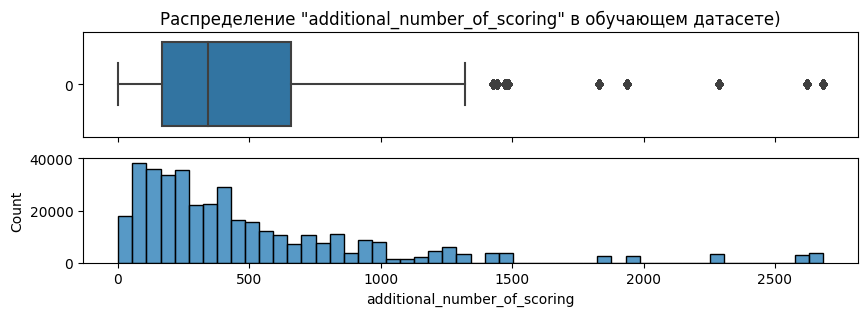

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.additional_number_of_scoring,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.additional_number_of_scoring,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "additional_number_of_scoring" в обучающем датасете)');

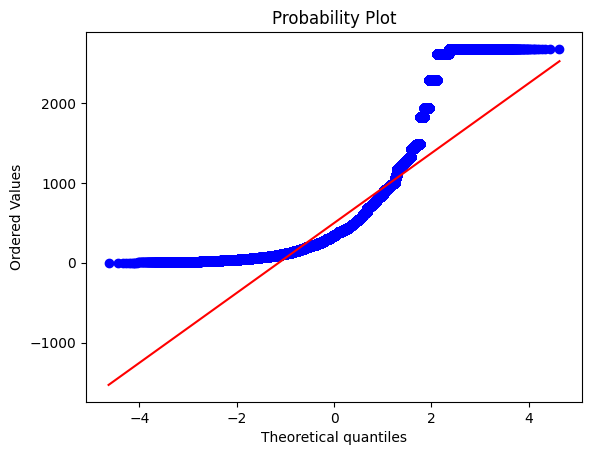

In [23]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.additional_number_of_scoring, plot=plt)
plt.show();

### 5. **`average_score`**: Стандартизация ###

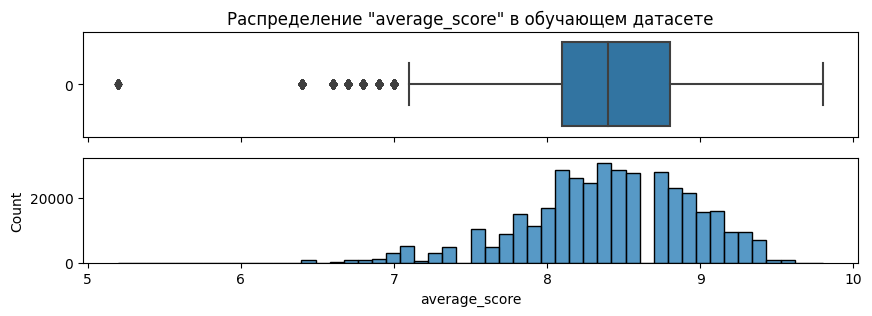

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.average_score,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.average_score,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "average_score" в обучающем датасете');

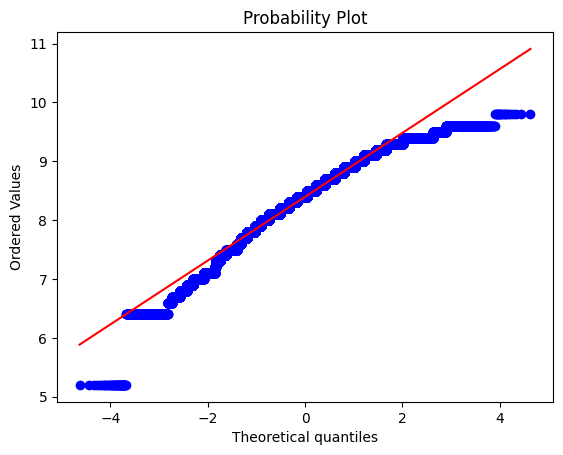

In [25]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.average_score, plot=plt)
plt.show();

In [225]:
'''
col_list = [
    'average_score',
]
s_scaler = preprocessing.StandardScaler()
for df_ in train_df, test_df:
    scaled_df = s_scaler.fit_transform(df_[col_list])
    scaled_df = pd.DataFrame(scaled_df, columns=col_list)
    df_.update(scaled_df)
'''


### 6. **`total_number_of_reviews`**: ###

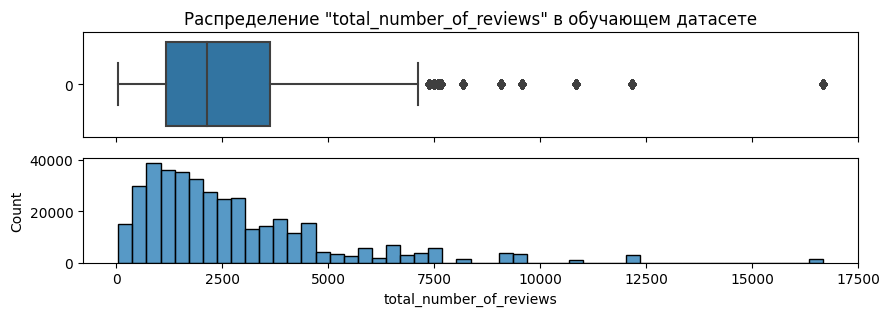

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.total_number_of_reviews,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.total_number_of_reviews,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "total_number_of_reviews" в обучающем датасете');

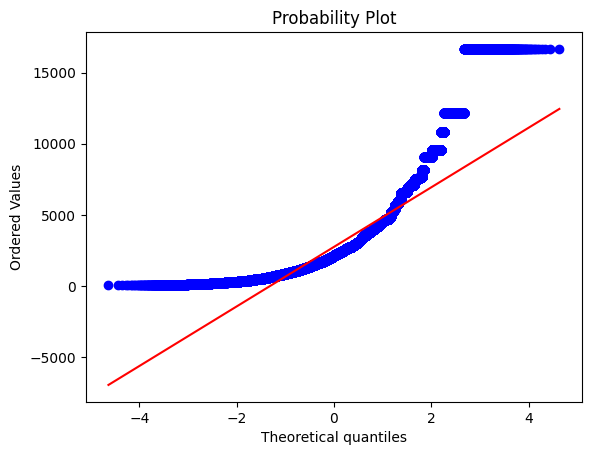

In [27]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.total_number_of_reviews, plot=plt)
plt.show();

### 7. **`total_number_of_reviews_reviewer_has_given`**: ###

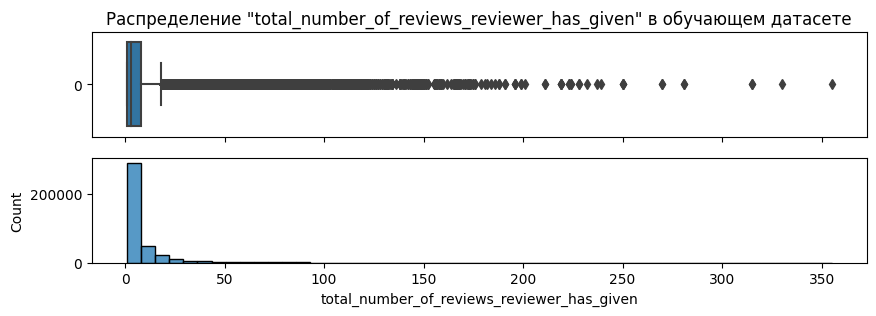

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.total_number_of_reviews_reviewer_has_given,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.total_number_of_reviews_reviewer_has_given,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "total_number_of_reviews_reviewer_has_given" в обучающем датасете');

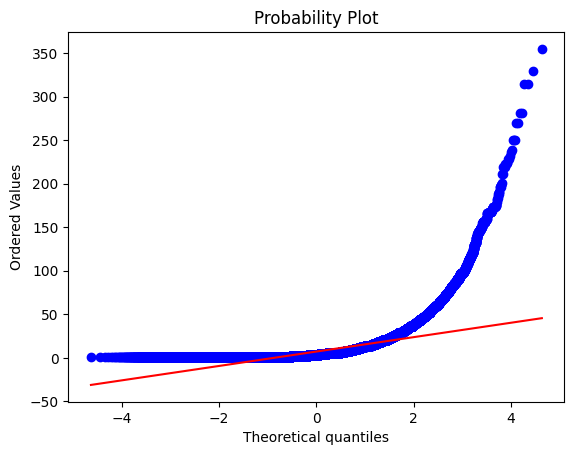

In [29]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.total_number_of_reviews_reviewer_has_given, plot=plt)
plt.show();

### 8. **`review_total_positive_word_counts`**: ###

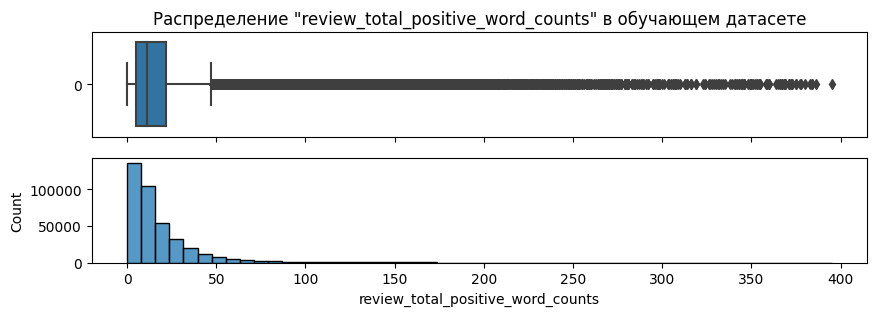

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.review_total_positive_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.review_total_positive_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "review_total_positive_word_counts" в обучающем датасете');

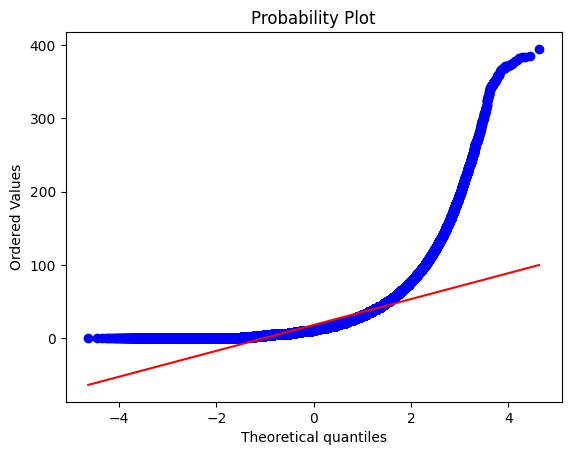

In [31]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.review_total_positive_word_counts, plot=plt)
plt.show();

### 9. **`review_total_negative_word_counts`**: ###

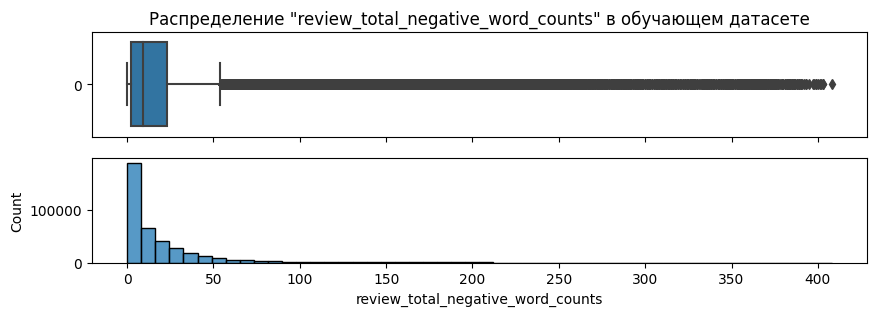

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), sharex=True)
sns.boxplot(
    data=train_df.review_total_negative_word_counts,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=train_df.review_total_negative_word_counts,
    bins=50,
    ax=axes[1]
)
axes[0].set_title('Распределение "review_total_negative_word_counts" в обучающем датасете');

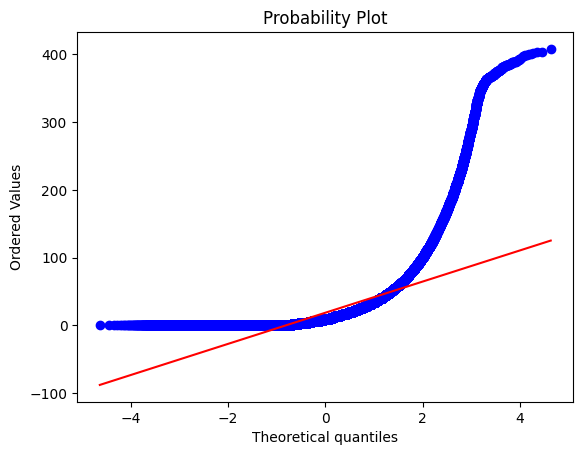

In [33]:
plt.subplot(1, 1, 1)
stats.probplot(train_df.review_total_negative_word_counts, plot=plt)
plt.show();

# Нормализация признаков #

In [34]:
col_list = [
    # 'stayed_nights',
    # 'additional_number_of_scoring',
    # 'average_score',
    # 'total_number_of_reviews',
    # 'total_number_of_reviews_reviewer_has_given',
    'review_total_positive_word_counts',
    'review_total_negative_word_counts'
]
r_scaler = preprocessing.RobustScaler()
for df_ in train_df, test_df:
    scaled_df = r_scaler.fit_transform(df_[col_list])
    scaled_df = pd.DataFrame(scaled_df, columns=col_list)
    df_.update(scaled_df)

### 10. **`reviewer_nationality`**: ###

In [35]:
# cdf = train_df.copy()
# country_list = list(cdf.reviewer_nationality.value_counts().nlargest(62).index)
country_list = list(train_df.reviewer_nationality.value_counts().nlargest(62).index)

# cdf.reviewer_nationality = cdf.reviewer_nationality.apply(lambda x: x if x in country_list else ' Other ')
train_df.reviewer_nationality = train_df.reviewer_nationality.apply(lambda x: x if x in country_list else ' Other ')
train_df.shape

(386803, 23)

In [36]:
b_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])

# for df_ in train_df, test_df:
#     b_country = b_encoder.fit_transform(df_.reviewer_nationality)
#     df_ = pd.concat([df_, b_country], axis='columns', ignore_index=True)
#     display(df_.head(2))

# b_country = b_encoder.fit_transform(cdf.reviewer_nationality)
b_country = b_encoder.fit_transform(train_df.reviewer_nationality)
# cdf = pd.concat([cdf, b_country], join='outer', axis=1)
train_df = pd.concat([train_df, b_country], join='outer', axis=1)
display(train_df.shape)
# display(b_country.shape)


(386803, 29)

In [37]:
display(b_country.shape)

(386803, 6)

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  float64       
 8   total_number_of_reviews                     386803 non-null  int64        

In [40]:
test_df.reviewer_nationality = test_df.reviewer_nationality.apply(lambda x: x if x in country_list else ' Other ')
test_df.shape

(128935, 22)

In [41]:
b_country = b_encoder.fit_transform(test_df.reviewer_nationality)
test_df = pd.concat([test_df, b_country], join='outer', axis=1)
display(test_df.shape)

(128935, 28)

In [42]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               128935 non-null  object        
 1   additional_number_of_scoring                128935 non-null  int64         
 2   review_date                                 128935 non-null  datetime64[ns]
 3   average_score                               128935 non-null  float64       
 4   hotel_name                                  128935 non-null  object        
 5   reviewer_nationality                        128935 non-null  object        
 6   negative_review                             128935 non-null  object        
 7   review_total_negative_word_counts           128935 non-null  float64       
 8   total_number_of_reviews                     128935 non-null  int64        

None

## Отбор признаков ##

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  float64       
 8   total_number_of_reviews                     386803 non-null  int64        

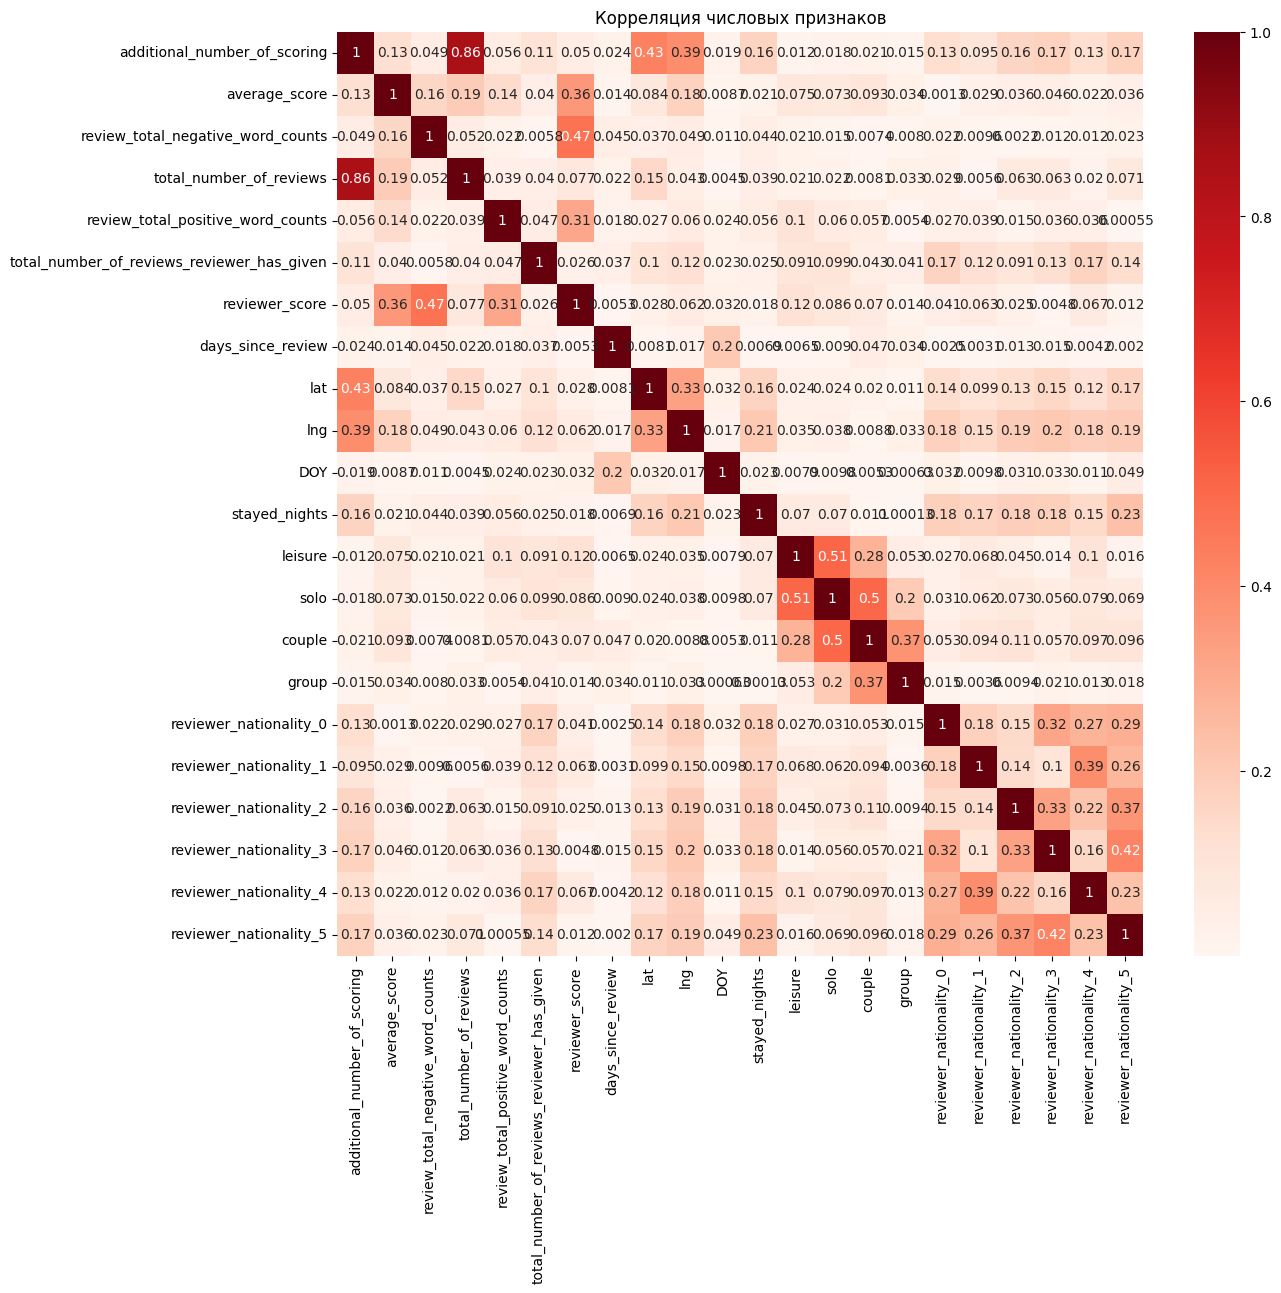

In [44]:
plt.figure(figsize=(13, 12))
heatmap = sns.heatmap(data=train_df.corr(method='spearman').abs(), annot=True, cmap='Reds')
heatmap.set_title('Корреляция числовых признаков')
plt.show()

In [45]:
drop_features_list = [
    'hotel_address',
    # 'additional_number_of_scoring',
    'review_date',
    # 'average_score',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    # 'review_total_negative_word_counts',
    # 'total_number_of_reviews',
    'positive_review',
    # 'review_total_positive_word_counts',
    # 'total_number_of_reviews_reviewer_has_given',
    # 'reviewer_score',
    'tags',
    # 'days_since_review',
    # 'city_Amsterdam',
    # 'city_Barcelona',
    # 'city_London',
    # 'city_Milan',
    # 'city_Paris',
    # 'city_Vienna',
    # 'lat',
    # 'lng'
]
for df_ in train_df, test_df:
    df_.drop(columns=drop_features_list, inplace=True)

## Обучение модели ##

In [46]:
X = train_df.drop(columns=['reviewer_score'])
y = train_df.reviewer_score
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE
                                                   )

In [47]:
regressor = RandomForestRegressor(
                                    n_estimators=100,
                                    n_jobs=4,
                                    random_state=RANDOM_STATE
                                 )
regressor.fit(X_train, y_train)
y_predictor = regressor.predict(X_test)

## Оценка качества модели ##

In [48]:
print(f'MAPE:', metrics.mean_absolute_percentage_error(y_test, y_predictor))

MAPE: 0.13578567158424534


## Оценка значимости признаков ##

In [49]:
display(pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False))

review_total_negative_word_counts             0.275685
review_total_positive_word_counts             0.155576
average_score                                 0.089158
days_since_review                             0.075291
DOY                                           0.074638
lat                                           0.050314
lng                                           0.050140
total_number_of_reviews                       0.044485
additional_number_of_scoring                  0.042555
total_number_of_reviews_reviewer_has_given    0.042331
stayed_nights                                 0.027609
couple                                        0.008596
leisure                                       0.008204
reviewer_nationality_2                        0.007267
reviewer_nationality_3                        0.007250
reviewer_nationality_5                        0.007147
solo                                          0.006988
reviewer_nationality_1                        0.006925
reviewer_n

## Формирование предсказаний ##

In [50]:
predictions = regressor.predict(test_df)
submission_df.reviewer_score = predictions
submission_df.head()

,reviewer_score,id
0,8.705,488440
1,7.294,274649
2,8.232,374688
3,9.551,404352
4,9.602,451596


In [51]:
submission_df.shape

(128935, 2)

In [52]:
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)